In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

import iqsq
from iqsq import (
    iq_cpu_naive,
    iq_cpu_opt_1,
    iq_gpu_naive,
    iq_gpu_opt_1,
    iq_gpu_opt_2,
    q_constants
)


In [2]:
scattering_factors_df = iqsq.build_scattering_factors_table(
    aff_elements_fp='GrSqf_cal_AP_Oct27/aff_elementonly.txt',
    aff_parameters_fp='GrSqf_cal_AP_Oct27/aff_parmonly.txt'
)
scattering_factors_df

,0,1,2,3,4,5,6,7,8
0,,,,,,,,,
H,0.489918,20.659300,0.262003,7.74039,0.196767,49.5519,0.049879,2.20159,0.001305
H1-,0.897661,53.136800,0.565616,15.18700,0.415815,186.5760,0.116973,3.56709,0.002389
He,0.873400,9.103700,0.630900,3.35680,0.311200,22.9276,0.178000,0.98210,0.006400
Li,1.128200,3.954600,0.750800,1.05240,0.617500,85.3905,0.465300,168.26100,0.037700
Li1+,0.696800,4.623700,0.788800,1.95570,0.341400,0.6316,0.156300,10.09530,0.016700
...,...,...,...,...,...,...,...,...,...
Pu6+,35.173600,0.473204,22.718100,2.73848,14.763500,11.5530,2.286780,20.93030,13.058200
Am,36.670600,0.483629,24.099200,3.20647,17.341500,14.3136,3.493310,102.27300,13.359200
Cm,36.648800,0.465154,24.409600,3.08997,17.399000,13.4346,4.216650,88.48340,13.288700


In [3]:
%load_ext line_profiler

In [4]:
atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/5IrC_r5a-1Ir.xyz")
atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)

In [5]:
# runs for ~1.8 seconds on bmo
# atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x1.xyz")
# atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
# %lprun -f iq_gpu_opt_1.calculate_iq \
#     iq_gpu_opt_1.calculate_iq( \
#         scattering_factors_df=sf_df, \
#         atom_distance_matrix_df=atom_distance_matrix_df, \
#         qmin=0.01, \
#         qmax=30, \
#         qstep=0.01 \
#     )

In [6]:
# in preparation for perturbing the atom positions
# find the minimum distance between atoms
# based on the result it looks like Ni-O pairs are at distance 2.0702
atom_distance_matrix_df[atom_distance_matrix_df > 0].min()

Ir    1.986588
O     1.999944
O     1.994748
O     1.995455
Ir    1.983893
O     1.978655
O     1.983893
Ir    1.978655
O     1.998288
O     1.997455
O     1.998288
O     1.998481
Ir    1.982764
Ir    1.982764
O     1.983547
O     1.998415
O     2.000090
I     1.994748
O     1.994748
O     1.994748
O     1.998288
O     1.998288
O     1.999036
O     1.999027
O     1.998288
O     1.999078
dtype: float64

In [7]:
atom_positions_df

,x,y,z
Ir,2.267,2.268,1.619
O,1.400,1.401,3.199
O,0.856,3.678,1.619
O,3.678,0.857,1.619
Ir,4.512,4.498,0.089
O,5.914,5.900,0.009
O,3.110,3.096,0.021
Ir,6.752,6.752,1.586
O,3.646,5.364,-1.490
O,3.604,5.406,1.619


In [8]:
# perturb the atom locations slightly to create a new set of atom positions
rng = np.random.default_rng()
perturbed_atom_positions_df = atom_positions_df + rng.normal(scale=0.1, size=atom_positions_df.shape)
perturbed_atom_distance_matrix_df = iqsq.build_atom_distance_matrix(perturbed_atom_positions_df)

In [9]:
qIq = iq_gpu_opt_2.calculate_iq(
    scattering_factors_df=scattering_factors_df,
    atom_distance_matrix_df=atom_distance_matrix_df,
    qmin=0.01,
    qmax=30,
    qstep=0.01
)

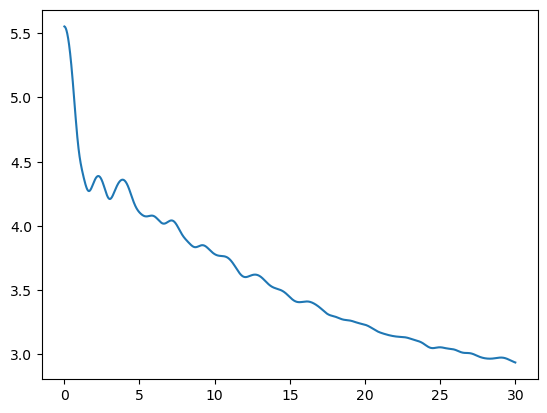

In [10]:
plt.plot(qIq[:,0],np.log10(qIq[:,1]))

In [11]:
perturbed_qIq = iq_gpu_opt_2.calculate_iq(
    scattering_factors_df=scattering_factors_df,
    atom_distance_matrix_df=perturbed_atom_distance_matrix_df,
    qmin=0.01,
    qmax=30,
    qstep=0.01
)

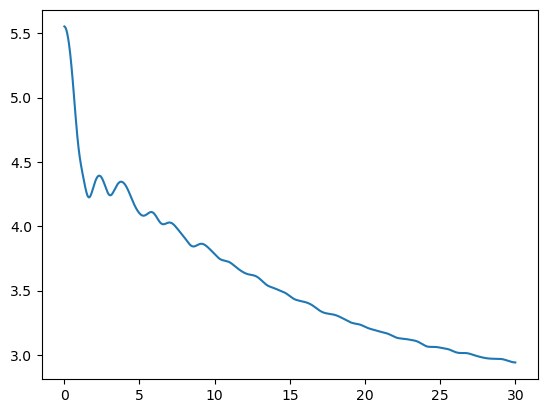

In [12]:
plt.plot(perturbed_qIq[:,0],np.log10(perturbed_qIq[:,1]))

In [13]:
from scipy.spatial.distance import euclidean

perturbed_atom_positions = perturbed_atom_positions_df.to_numpy()

def Iq_cost(x, *args, return_qIq=False):
    _atom_positions_deltas = np.reshape(x, perturbed_atom_positions_df.shape)
    _atom_positions_df = perturbed_atom_positions_df + _atom_positions_deltas
    _atom_distance_matrix_df = iqsq.build_atom_distance_matrix(_atom_positions_df)
    _qIq = iq_gpu_opt_2.calculate_iq(
        scattering_factors_df=scattering_factors_df,
        atom_distance_matrix_df=_atom_distance_matrix_df,
        qmin=0.01,
        qmax=30,
        qstep=0.01
    )

    cost = euclidean(np.log(_qIq[:,1]), np.log(qIq[:,1]))
    #print(f"Iq_cost: {cost}")

    if return_qIq:
        return cost, _qIq
    else:
        return cost

In [14]:
def display_best_cost(x, f, accept):
    cost, qIq = Iq_cost(x, return_qIq=True)
    # this is displayed when disp=True
    #print(f"best cost so far: {cost}")
    plt.plot(qIq[:,0],np.log10(qIq[:,1]))

parameter count: 78
basinhopping step 0: f 6.28028e-05
basinhopping step 1: f 0.582497 trial_f 0.582497 accepted 1  lowest_f 6.28028e-05
basinhopping step 2: f 0.31231 trial_f 0.31231 accepted 1  lowest_f 6.28028e-05
basinhopping step 3: f 0.241158 trial_f 0.241158 accepted 1  lowest_f 6.28028e-05
basinhopping step 4: f 0.285423 trial_f 0.285423 accepted 1  lowest_f 6.28028e-05
basinhopping step 5: f 0.450927 trial_f 0.450927 accepted 1  lowest_f 6.28028e-05
basinhopping step 6: f 0.765601 trial_f 0.765601 accepted 1  lowest_f 6.28028e-05
basinhopping step 7: f 0.553347 trial_f 0.553347 accepted 1  lowest_f 6.28028e-05
basinhopping step 8: f 0.538863 trial_f 0.538863 accepted 1  lowest_f 6.28028e-05
basinhopping step 9: f 0.66283 trial_f 0.66283 accepted 1  lowest_f 6.28028e-05
basinhopping step 10: f 0.564775 trial_f 0.564775 accepted 1  lowest_f 6.28028e-05
CPU times: user 8h 7min 34s, sys: 21min 10s, total: 8h 28min 44s
Wall time: 8h 1min 2s


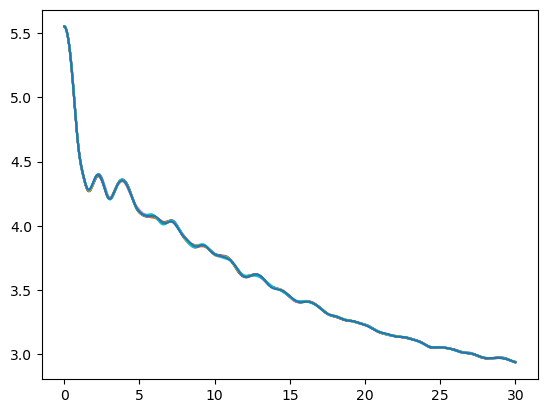

In [15]:
from scipy.optimize import basinhopping

parameter_count = atom_positions_df.shape[0] * atom_positions_df.shape[1]
print(f"parameter count: {parameter_count}")
%time de_result = basinhopping( \
    func=Iq_cost, \
    x0=rng.normal(scale=0.1, size=np.prod(atom_positions_df.shape)), \
    niter=10, \
    disp=True, \
    callback=display_best_cost, \
)

In [16]:
de_result

                        fun: 6.280283213944433e-05
 lowest_optimization_result:       fun: 6.280283213944433e-05
 hess_inv: array([[ 0.473868  ,  0.19628177,  0.27693127, ...,  0.2262984 ,
         0.37203826,  0.70294584],
       [ 0.19628177,  0.59766763,  0.34725078, ...,  0.24249152,
         0.47009747,  0.80525974],
       [ 0.27693127,  0.34725078,  0.41963128, ...,  0.20832791,
         0.39153122,  0.69289919],
       ...,
       [ 0.2262984 ,  0.24249152,  0.20832791, ...,  0.75117334,
        -0.28651534,  0.49744205],
       [ 0.37203826,  0.47009747,  0.39153122, ..., -0.28651534,
         1.04611359,  0.84099758],
       [ 0.70294584,  0.80525974,  0.69289919, ...,  0.49744205,
         0.84099758,  2.14641886]])
      jac: array([ 0.64537504,  0.66313106, -0.11143047, -0.03521016, -0.03771098,
        0.06772642,  0.00172255,  0.07482186, -0.00627783,  0.0767364 ,
        0.00490035, -0.00827029, -0.13416477, -0.14726047,  0.52573647,
        0.00177181,  0.00353352, -0.

In [17]:
atom_positions = atom_positions_df.to_numpy()
de_position_offsets = np.reshape(de_result.x, atom_positions.shape)
de_atom_positions = perturbed_atom_positions + de_position_offsets

In [18]:
plt.ion()

In [19]:
def plot_Iq(_ax, _atom_distance_matrix_df):
    _qIq = iq_gpu_opt_2.calculate_iq(
        scattering_factors_df=scattering_factors_df,
        atom_distance_matrix_df=_atom_distance_matrix_df,
        qmin=0.01,
        qmax=30,
        qstep=0.01
    )

    _ax.plot(_qIq[:,0],np.log10(_qIq[:,1]))

    return _qIq

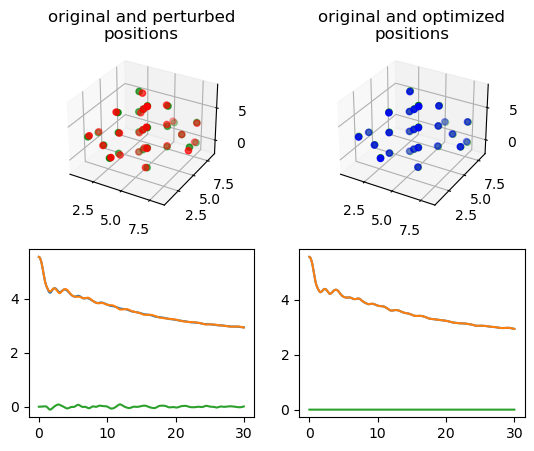

In [20]:
perturbed_fig = plt.figure()
a3 = perturbed_fig.add_subplot(2, 2, 1, projection='3d')
a3.set_title("original and perturbed\npositions")
a3.scatter(
    perturbed_atom_positions[:, 0],
    perturbed_atom_positions[:, 1],
    perturbed_atom_positions[:, 2],
    color='r'
)
a3.scatter(
    atom_positions[:, 0],
    atom_positions[:, 1],
    atom_positions[:, 2],
    color='g'
)

ax_Iq = perturbed_fig.add_subplot(2, 2, 3)
perturbed_qIq = plot_Iq(ax_Iq, perturbed_atom_distance_matrix_df)
original_qIq = plot_Iq(ax_Iq, atom_distance_matrix_df)
ax_Iq.plot(perturbed_qIq[:, 0], np.log(perturbed_qIq[:, 1]) - np.log(original_qIq[:, 1]))

de_a3 = perturbed_fig.add_subplot(2, 2, 2, projection='3d')
de_a3.set_title("original and optimized\npositions")
de_a3.scatter(
    de_atom_positions[:, 0],
    de_atom_positions[:, 1],
    de_atom_positions[:, 2],
    color='b'
)
de_a3.scatter(
    atom_positions[:, 0],
    atom_positions[:, 1],
    atom_positions[:, 2],
    color='g'
)


de_ax_Iq = perturbed_fig.add_subplot(2, 2, 4)

de_atom_positions_df = perturbed_atom_positions_df + de_position_offsets
de_atom_distance_matrix_df = iqsq.build_atom_distance_matrix(de_atom_positions_df)

de_qIq = plot_Iq(de_ax_Iq, de_atom_distance_matrix_df)
original_qIq = plot_Iq(de_ax_Iq, atom_distance_matrix_df)
de_ax_Iq.plot(perturbed_qIq[:, 0], np.log(de_qIq[:, 1]) - np.log(original_qIq[:, 1]))
